In [2]:
#Multilayer Perceptron
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt

dataset = ["iris",
              "Enfermedad_Cardiaca"]

In [3]:
def LeerDatos(filename : str, separa : str, header = True):
    if (header):
        data = pd.read_csv(filename + ".csv", sep =separa, header = 0)
    else:
        data = pd.read_csv(filename+ ".csv", sep = separa, header = None)
    #data = data.sample(frac = 1) #shuffle data
    data = data.sort_values(data.columns[-1])
    return data.to_numpy()

In [4]:
def Normalizar_Datos(data : np.array):
    #normal = np.empty_like(data)
    for i in range (0,np.size(data[0])):
        media = np.mean(data[:,i])
        desvi =np.std(data[:,i])
        data[:,i] = (data[:,i] - media)/desvi
    return data

In [5]:
def Crear_k_folds(data : np.array , k:int, clases: []):
    folds = []
    tot_clase = []
    prop_clase = [] #Acumulado de indices
    pre_fold = []

    m = np.size(data[:,-1]) #numero de datos
    #n = np.size(data[0])
    for i in clases:
        tot_clase.append(np.count_nonzero( data[:,-1] == i))

    prop_clase.append(tot_clase[0])
    for i in range (1, len(tot_clase)):
        prop_clase.append( prop_clase[i-1] + tot_clase[i])

    pos_ini = 0
    for i in range(0, len(clases)):
        pre_fold.append(np.array_split(data[pos_ini:prop_clase[i]], k))
        pos_ini = prop_clase[i]
    
    for i in range (0,k):
        temp = np.empty( (0,np.size(data[0])) )
        for j in range(0,len(clases)):
            temp = np.vstack( (temp,pre_fold[j][i]))
        folds.append(temp)
            
    return folds

In [6]:
def Sigmoidal(X:np.array, theta:np.array):
    pot = X.dot(theta)
    return 1/(1+ np.exp(-pot))

In [7]:
def ds(D : np.array):
    return D*(1-D)

In [8]:
def Calcular_Funcion_Costo(X: np.array, y:np.array):
    #J(theta) = -1/m[ SUM( y* log(h(x)) + (1-y)*log(1-h(x)))
    m = np.size(X[:,0]) #numero de datos
    costo = 0
    for i in range(0, len(X[0])):
        costo += -1/m * ( np.sum( y[i].dot(np.log(X[i])) + (1-y[i]).dot( np.log(1-X[i]))) )
    return costo

In [9]:
def GenerarW( num_capas : int, dim_capas = []):
    W = {}
    for i in range(0,num_capas+1):
        if (i == 0):
            temp = np.random.randn( dim_capas[i], dim_capas[i+1] )
            W[i] = temp
        if (i != 0):
            temp = np.random.randn( dim_capas[i]+1, dim_capas[i+1] )
            W[i] = temp       
    return W


In [10]:
def Forward (X: np.array, W : {}): 
    A = {}
    h_l = X
    A[0] = h_l
    for i in range(0, len(W)):
        if (i == len(W)-1):
            h_l = Sigmoidal(h_l, W[i])
        else:
            h_l = Sigmoidal(h_l, W[i])
            bias = np.ones( (np.size(h_l[:,0]),1) )
            h_l = np.hstack( (bias,h_l) )
     
        A[i+1] = h_l   
    return A

def Backward (X: np.array, y: np.array, W:{}, A:{}, tasa_apren:float):
    #Actualizacion de W (pesos) de la red por back-propagation   
    #deriv J(theta) = a^l* delta^(l+1)
    #g'(z) = a * (1-a)
    m = np.size(X[:,-1])
    delta_t = (A[len(A)-1] - y) #* ds(A[len(A)-1])
    for i in range(len(W)-1,-1,-1):
        R = tasa_apren* ((A[i].T.dot(delta_t))/ m)
        if (i == len(W)-1):
            W[i]-= R #tasa_apren* (A[i].T.dot(delta_t))/ m
            delta_t = ds(A[i])*(delta_t.dot(W[i].T))
        else:
            R = R[:,1:]
            W[i]-= R # tasa_apren* (A[i].T.dot(delta_t))/ m
        if (i != len(W)-1  and i != 0):
            delta_t = ds(A[i])*(delta_t[:,1:].dot(W[i].T))
            

In [11]:
def Gradiente_Descendiente(X: np.array, y:np.array, W:{},
                          num_itera:int, tasa_apren:float):
    arr_costo = np.empty(num_itera, dtype =float)
    A = {}
    num_capas = len(W)
 
    for it in range(0, num_itera):
        A = Forward(X, W)
        arr_costo[it] = Calcular_Funcion_Costo(A[num_capas], y)
        Backward(X, y, W, A, tasa_apren)      
    return A[num_capas], arr_costo, W

In [12]:
def TransformacionOneShot(y: np.array, clases:[]):
    num_clases = len(clases)
    vec_clases = np.empty((0,num_clases), dtype = int)
    for i in y:
        idx = clases.index(i)
        vec = [0] * num_clases
        vec[idx] = 1
        vec_clases = np.vstack ((vec_clases, vec))
    return vec_clases

def OneShot_Salida(y:np.array):
    y_cat = np.zeros_like(y)
    max = np.argmax(y, axis = 1)
    for i in range(0, len(max)):
        y_cat[i,max[i]] = 1
    return y_cat

In [13]:
def Calcular_Accuracy(X:np.array, y:np.array, theta:np.array):
    y_calc = Forward(X, theta)
    y_calc = OneShot_Salida(y_calc[len(y_calc)-1])
    aciertos = 0
    
    for i in (y - y_calc):
        if (np.count_nonzero(i) == 0):
            aciertos += 1
    return aciertos/np.size(y[:,0])
    
def PromedioAccuracy(test:np.array, theta, k, clases):
    accu = np.zeros(k)
    for i in range(0,k):
        X_test = test[i][:,:-1]
        X_test = X_test.astype('float64')
        X_test = Normalizar_Datos(X_test)

        y_test = TransformacionOneShot(test[i][:,-1], clases)

        accu[i] = Calcular_Accuracy(X_test, y_test, theta)
    return accu.mean()

In [14]:
def CalculoParametros(folds:[], k:int, iteraciones:int, alpha:float,
 num_clases:int, num_capa_hidden:int, num_neurona: int, clases:[]):
    arr_costo = []
    arr_theta = []
    arr_test = []
    for test_i in range(0, k):
        test = folds[test_i] 
        train = np.zeros( (0,np.size(folds[0][0])) )
        for train_i in range (0, k):         
            if (train_i == test_i):
                continue
            else:
                train = np.vstack( (train,folds[train_i]) )
            
        costo = []
        X_train = train[:,:-1]
        X_train = X_train.astype('float64')
        X_train = Normalizar_Datos(X_train)

        N = np.size(X_train[:,-1]) #tamaño batch
        D_in = np.size(X_train[0]) #dimension entrada
        D_out = num_clases

        #Generacion array de capas
        array_capas = []
        array_capas.append(D_in)
        for i in range(0, num_capa_hidden):
            array_capas.append(num_neurona)
        array_capas.append(D_out)

        W = GenerarW(num_capa_hidden, array_capas)

        y_train = TransformacionOneShot( train[:,-1], clases)

        theta, costo, W = Gradiente_Descendiente(X_train, y_train, W, iteraciones, alpha)
        arr_theta.append(theta)
        arr_costo.append(costo)
        arr_test.append(test)
      
    return theta, arr_costo, arr_test, W

In [15]:
def CalculoCustom(folds:[], k:int, iteraciones:int, alpha:float,
 num_clases:int, num_capa_hidden:int, num_neurona: [], clases:[]):
    arr_costo = []
    arr_theta = []
    arr_test = []
    for test_i in range(0, k):
        test = folds[test_i] 
        train = np.zeros( (0,np.size(folds[0][0])) )
        for train_i in range (0, k):         
            if (train_i == test_i):
                continue
            else:
                train = np.vstack( (train,folds[train_i]) )
            
        costo = []
        X_train = train[:,:-1]
        X_train = X_train.astype('float64')
        X_train = Normalizar_Datos(X_train)

        N = np.size(X_train[:,-1]) #tamaño batch
        D_in = np.size(X_train[0]) #dimension entrada
        D_out = num_clases

        #Generacion array de capas
        array_capas = []
        array_capas.append(D_in)
        for i in range(0, num_capa_hidden):
            array_capas.append(num_neurona[i])
        array_capas.append(D_out)
        
        W = GenerarW(num_capa_hidden, array_capas)

        y_train = TransformacionOneShot( train[:,-1], clases)

        theta, costo, W = Gradiente_Descendiente(X_train, y_train, W, iteraciones, alpha)
        arr_theta.append(theta)
        arr_costo.append(costo)
        arr_test.append(test)
      
    return theta, arr_costo, arr_test, W

In [16]:
def BusquedaParametros(folds:[], k, num_clases, clases:[]):
    alpha = [0.1, 0.25, 0.5, 0.75, 1.0]
    iteraciones = range(500,3501,500)
    num_capa = [1,2,3]
    num_neurona = range(5,20,5)
    arr_accu = np.empty( (len(alpha),len(iteraciones) ))
    for nc in num_capa:
        print ("############################")
        print ("Numero de hidden layers: ", nc)
        print ("############################")
        for nn in num_neurona:
            print ("Numero de neuronas x layer: ", nn)
            for tasa in range(0,len(alpha)):
                for it in range(0, len(iteraciones)):
                    theta, dummy, test, W = CalculoParametros(folds, k, iteraciones[it], alpha[tasa], num_clases, nc, nn, clases)

                    arr_accu[tasa,it] = PromedioAccuracy(test, W, k, clases)

            print(pd.DataFrame(arr_accu, index = alpha, columns = iteraciones))

In [17]:
iris = LeerDatos(dataset[0], separa = ',')
clases = ["Setosa", "Versicolor", "Virginica"]
iris_folds = Crear_k_folds(iris, 3, clases)
#theta, arr_costo, arr_test = CalculoParametros(iris_folds, 3, 500, 0.1, 3, 3, 20, clases)


In [18]:
BusquedaParametros(iris_folds, 3, num_clases = 3, clases = clases)

############################
Numero de hidden layers:  1
############################
Numero de neuronas x layer:  5
           500      1000      1500      2000      2500      3000      3500
0.10  0.845997  0.893791  0.893791  0.887255  0.906863  0.939951  0.939951
0.25  0.887255  0.913807  0.939951  0.926879  0.946895  0.953431  0.973039
0.50  0.906863  0.940359  0.966503  0.973039  0.973039  0.973039  0.973039
0.75  0.933415  0.973039  0.973039  0.973039  0.973039  0.979984  0.979984
1.00  0.939951  0.973039  0.979984  0.979984  0.979984  0.979984  0.979984
Numero de neuronas x layer:  10
           500      1000      1500      2000      2500      3000      3500
0.10  0.859886  0.927288  0.926879  0.913807  0.933415  0.940359  0.953431
0.25  0.914216  0.940359  0.940359  0.973039  0.973039  0.973039  0.973039
0.50  0.940359  0.959967  0.973039  0.973039  0.979984  0.973039  0.973039
0.75  0.940359  0.973039  0.979984  0.979984  0.979984  0.979984  0.979984
1.00  0.966503  0.973039  

In [19]:
cardiaca = LeerDatos(dataset[1], separa = '\t')
clas_cardiaca = [0,1]
cardiaca_folds = Crear_k_folds(cardiaca, 3, clas_cardiaca)

In [20]:
BusquedaParametros(cardiaca_folds, k=3, num_clases = 2, clases = clas_cardiaca)

############################
Numero de hidden layers:  1
############################
Numero de neuronas x layer:  5
           500      1000      1500      2000      2500      3000      3500
0.10  0.854785  0.844884  0.854785  0.874587  0.887789  0.854785  0.877888
0.25  0.881188  0.864686  0.874587  0.884488  0.894389  0.861386  0.894389
0.50  0.874587  0.891089  0.907591  0.887789  0.894389  0.900990  0.884488
0.75  0.867987  0.891089  0.894389  0.904290  0.887789  0.871287  0.887789
1.00  0.894389  0.914191  0.887789  0.867987  0.871287  0.891089  0.907591
Numero de neuronas x layer:  10
           500      1000      1500      2000      2500      3000      3500
0.10  0.851485  0.864686  0.871287  0.874587  0.891089  0.887789  0.867987
0.25  0.864686  0.877888  0.884488  0.877888  0.924092  0.900990  0.910891
0.50  0.871287  0.884488  0.914191  0.904290  0.914191  0.904290  0.907591
0.75  0.917492  0.891089  0.910891  0.917492  0.914191  0.924092  0.927393
1.00  0.907591  0.904290  

In [21]:
def PloteoCurvaCosto (arr: np.array, title):       
    #arr_theta.append(theta_grad[-1])
    #print (pd.DataFrame(arr))
    fig, ax = plt.subplots()
    #Ploteo de Curva
    scale = 1.0
    color = 'tab:blue'
    iteraciones = len(arr)
    plt.plot(range(0,iteraciones), arr, 'o', linewidth=1, markersize=2 )

    plt.title(title, {'fontsize':10})
    ax.set(xlim = [-10,iteraciones], ylim = (np.min(arr)-0.01, np.max(arr)+0.01))
    ax.grid(True)
    plt.xlabel('Iteración')
    plt.ylabel('Costo')
    plt.show()

In [30]:
#Calculo con número de neuronas por capa a elección
num_neurona = [15]
theta, arr_costo, arr_test, W = CalculoCustom(iris_folds, k=3, iteraciones=1500,alpha=0.5, num_clases=3, num_capa_hidden=1, num_neurona=num_neurona, clases=clases)

acc = PromedioAccuracy(arr_test, W, k=3, clases=clases)

In [31]:
acc

0.9730392156862746

In [32]:
arr_costo

[array([0.24774636, 0.18106615, 0.13028321, ..., 0.00080409, 0.00080314,
        0.0008022 ]),
 array([0.06137345, 0.02833712, 0.01778977, ..., 0.00077634, 0.00077574,
        0.00077513]),
 array([0.03048171, 0.01606786, 0.01087089, ..., 0.0010139 , 0.00101296,
        0.00101202])]

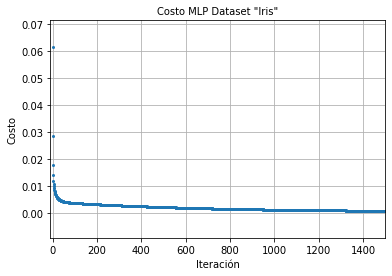

In [79]:
PloteoCurvaCosto(arr_costo[1], "Costo MLP Dataset \"Iris\"")

In [76]:
#Calculo con número de neuronas por capa a elección
num_neurona = [15,15]
theta, costo_card, arr_test, W = CalculoCustom(cardiaca_folds, k=3, iteraciones=2000,alpha=1.0, num_clases=2, num_capa_hidden=2, num_neurona=num_neurona, clases=clas_cardiaca)

acc = PromedioAccuracy(arr_test, W, k=3, clases=clas_cardiaca)
acc

0.9306930693069306

In [77]:
arr_costo

[array([0.24774636, 0.18106615, 0.13028321, ..., 0.00080409, 0.00080314,
        0.0008022 ]),
 array([0.06137345, 0.02833712, 0.01778977, ..., 0.00077634, 0.00077574,
        0.00077513]),
 array([0.03048171, 0.01606786, 0.01087089, ..., 0.0010139 , 0.00101296,
        0.00101202])]

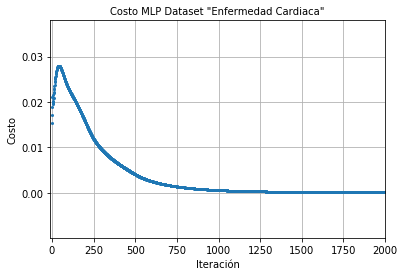

In [80]:
PloteoCurvaCosto(costo_card[2], "Costo MLP Dataset \"Enfermedad Cardiaca\"")